# Time and Space in Brazilian interstate bus routes

## Exploratory data analysis

### Source: Dados Abertos ANTT

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import descartes
import geopandas as gpd
from shapely.geometry import Point, Polygon
import string
import geopy
from geopy import distance
import unidecode
import networkx as nx
import cartopy

%matplotlib inline

We can start by importing our data of bus routes and Brazilian municipalities. These databases can be found [here](https://dados.antt.gov.br/organization/agencia-nacional-de-transportes-terrestres-antt) and [here](ftp://geoftp.ibge.gov.br/organizacao_do_territorio/estrutura_territorial/localidades) respectively. I have already worked with some of them before, so they may have more columns than the original file.

In [3]:
# Importing data of the bus routes and municipalities codes and GPS coord

data_bus = pd.read_csv('data_bus_v4.csv')

data_bus = data_bus.drop(["Unnamed: 0", "lat", "lon"],axis=1)

municipios_ibge = pd.read_csv('municipiosibge.csv')

municipios_ibge = municipios_ibge.drop("Unnamed: 0",axis=1)

print(data_bus.shape, municipios_ibge.shape)

(1308793, 18) (5572, 8)


Our .shape attribute tells us that `data_bus` has 1.308.793 lines and 18 columns, while `municipios_ibge` has 5572 lines and 8 columns. Let's take a quick look in them.

In [4]:
data_bus.head()

,codigo_viagem,empresa,nu_linha,onibus,tipo_viagem,sentido_linha,in_transbordo,origem,destino,pdop,data_viagem_programada,data_inicio_viagem,data_fim_viagem,origem_lat,origem_lon,destino_lat,destino_lon,dist
0,554e2d76,7980c0ae,83ed87ea,3b3307d2,regular,volta,não,"TRES RIOS, RJ","JUIZ DE FORA, MG",0,2019-01-01 05:30:00,2019-01-01 05:28:27,2019-01-01 06:52:04,-22.1165,-43.2185,-21.7595,-43.3398,41.469048
1,c5f130e7,7980c0ae,83ed87ea,651283f4,regular,volta,não,"TRES RIOS, RJ","JUIZ DE FORA, MG",0,2019-01-01 05:30:00,2019-01-01 05:30:01,2019-01-01 06:53:37,-22.1165,-43.2185,-21.7595,-43.3398,41.469048
2,09644e23,7980c0ae,83ed87ea,3b3307d2,regular,ida,não,"TRES RIOS, RJ","JUIZ DE FORA, MG",0,2019-01-01 07:30:00,2019-01-01 07:29:41,2019-01-01 08:52:25,-22.1165,-43.2185,-21.7595,-43.3398,41.469048
3,7e637eb5,7980c0ae,83ed87ea,651283f4,regular,volta,não,"TRES RIOS, RJ","JUIZ DE FORA, MG",0,2019-01-01 07:30:00,2019-01-01 07:30:50,2019-01-01 08:58:33,-22.1165,-43.2185,-21.7595,-43.3398,41.469048
4,99db53b2,7980c0ae,83ed87ea,8ddac9ca,regular,ida,não,"TRES RIOS, RJ","JUIZ DE FORA, MG",0,2019-01-01 08:45:00,2019-01-01 08:32:36,2019-01-01 10:14:54,-22.1165,-43.2185,-21.7595,-43.3398,41.469048


In [5]:
municipios_ibge.head()

,codigo_ibge,nome,latitude,longitude,capital,codigo_uf,uf,nome_uf
0,5200050,Abadia de Goiás,-16.75730,-49.4412,0,52,GO,"ABADIA DE GOIAS, GO"
1,3100104,Abadia dos Dourados,-18.48310,-47.3916,0,31,MG,"ABADIA DOS DOURADOS, MG"
2,5200100,Abadiânia,-16.19700,-48.7057,0,52,GO,"ABADIANIA, GO"
3,3100203,Abaeté,-19.15510,-45.4444,0,31,MG,"ABAETE, MG"
4,1500107,Abaetetuba,-1.72183,-48.8788,0,15,PA,"ABAETETUBA, PA"


## Improving the database

### Adding new variables

As I've already worked with `data_bus` before, there are already columns of `longitude` and `latitude`, but `municipios_ibge` has another interesting column: `capital`, which is a binary variable telling us whether or not a given city is a state capital. We can add two new columns to our `data_bus`: `capital_origem` and `capital_destino`.

In [6]:
# Creating a set with all cities that are in your database

cidades = set()

for i in data_bus.origem:
    if i in cidades:
        pass
    else:
        cidades.add(i)
        
for i in data_bus.destino:
    if i in cidades:
        pass
    else:
        cidades.add(i)

# Creating a dict {city:capital}. It's way faster than using a for loop inside our data_bus querying municipios_ibge.capital
        
capital_cidades = dict()

for city in cidades:
    capital_cidades[city] = municipios_ibge.capital[municipios_ibge.nome_uf == city].iloc[0]

data_bus["capital_origem"] = [capital_cidades[city] for city in data_bus.origem]
data_bus["capital_destino"] = [capital_cidades[city] for city in data_bus.destino]

### Quality of time data

We see that columns `data_inicio_viagem` and `data_fim_viagem` are a string type. It's time to make them useful with the help of `datatime`.

With `datetime.fromisoformat` and `datatime.timedelta` classes, we're going to create five new columns in our `data_bus` DataFrame, with workable datetime data:
- `data_viagem_programada`: replace of the old column
- `data_inicio_viagem`: replace of the old column
- `data_fim_viagem`: replace of the old column
- `time_inicio_fim`: using `timedelta` to calculate the passing of time between embarking and disembarking in hours
- `delay`: using `timedelta` to calculate delay between `data_viagem_programada` and `data_inicio_viagem` in minutes

In [7]:
from datetime import datetime, timedelta

data_bus["data_viagem_programada"] = [datetime.fromisoformat(data_bus.data_viagem_programada[i]) for i in range(data_bus.shape[0])]
data_bus["data_inicio_viagem"] = [datetime.fromisoformat(data_bus.data_inicio_viagem[i]) for i in range(data_bus.shape[0])]
data_bus["data_fim_viagem"] = [datetime.fromisoformat(data_bus.data_fim_viagem[i]) for i in range(data_bus.shape[0])]
data_bus["time_inicio_fim"] = [(data_bus["data_fim_viagem"][i] - data_bus["data_inicio_viagem"][i]) / timedelta(hours = 1) for i in range(data_bus.shape[0])]
data_bus["delay"] = [(data_bus["data_inicio_viagem"][i] - data_bus["data_viagem_programada"][i]) / timedelta(minutes = 1) for i in range(data_bus.shape[0])]

We see that our `delay` variable may be positive or negative, and so can `time_inicio_fim`. For the former, it can be interpreted as positive meaning a delay and negative meaning an anticipated departure, while the latter is certainly a problem with the 12-hour clock format (you can't travel back in time, at least not in Brazilian interstate buses).

To avoid further problems, let's filter these lines.

In [12]:
print("Negative delay values: " + str((data_bus.delay < 0).value_counts()[True] / data_bus.shape[0]))

print("Negative time_inicio_fim values: " + str((data_bus.time_inicio_fim < 0).value_counts()[True] / data_bus.shape[0]))

Negative delay values: 0.711922358997947
Negative time_inicio_fim values: 0.18524166923264412


Basically, $18.5\%$ of our lines are with negative `time_inicio_fim` values and $71.1\%$ with negative `delay` values.

A different path would be to calculate a threshold value for travel time, using the column `dist`. As it was calculated using [geodesic distance](https://doi.org/10.1007%2Fs00190-012-0578-z), we may consider it to be the shortest distance between two cities, as our other distance value, that implicit in the difference between departure and arrival time, is conditioned to the highway inherent landform change of direction.

In [13]:
rows_negative = []

drop_negative_rows = data_bus.query('delay < 0 or time_inicio_fim < 0')

data_bus_f = data_bus.drop(drop_negative_rows.index, axis = 0)

Let's also drop `time_inicio_fim` that have values greater than 24 hours or less than 25 minutes and delay time greater than 5 hours.

In [14]:
drop_time_values_rows = data_bus_f.query('time_inicio_fim > 24 or time_inicio_fim < 0.41 or delay > 300')

data_bus_f = data_bus_f.drop(drop_time_values_rows.index, axis = 0)

In [15]:
data_bus_f.time_inicio_fim.describe(),"",data_bus_f.delay.describe()

(count    140545.000000
 mean          6.964299
 std           7.120976
 min           0.410000
 25%           2.053889
 50%           4.048056
 75%           7.943889
 max          24.000000
 Name: time_inicio_fim, dtype: float64,
 '',
 count    140545.000000
 mean         36.004978
 std          63.510259
 min           0.000000
 25%           1.683333
 50%           4.816667
 75%          24.433333
 max         300.000000
 Name: delay, dtype: float64)

Using `.describe()` we can see that our mean for `time_inicio_fim` is 7 hours and for `delay` is 36 minutes.

## Bus companies

### The biggest companies

Who are the biggest bus companies operating interstate routes?

In [118]:
print("Companies: " + str(data_bus.groupby("empresa").count().shape[0])+",", "buses: " + str(data_bus.groupby('onibus').nunique().shape[0]))

Companies: 136, buses: 11233


In [86]:
companies = set() # Saving all companies for reference
for company in data_bus.empresa:
    companies.add(company)
    
buses = set() # Saving all buses for reference
for bus in data_bus.onibus:
    buses.add(bus)

There are 136 companies and 11,233 buses within our filtered database. Who are the 5 biggest?

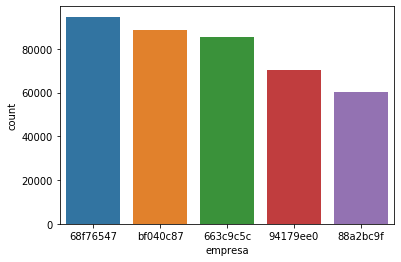

In [17]:
big_5 = list(dict(data_bus.empresa.value_counts()[0:5]).keys()) # The 5 biggest companies by routes travalled
sns.countplot(x="empresa", data=data_bus.query('empresa == @big_5'), 
              order = data_bus.query('empresa == @big_5')['empresa'].value_counts().index);

How many buses each of the top 5 have?

In [88]:
bus_big_5 = dict()
for company in big_5:
    bus_big_5[company] = (dict(data_bus.groupby('empresa')['onibus'].nunique())[company])

bus_big_5

{'68f76547': 901,
 'bf040c87': 709,
 '663c9c5c': 938,
 '94179ee0': 687,
 '88a2bc9f': 818}

### Number of buses per company

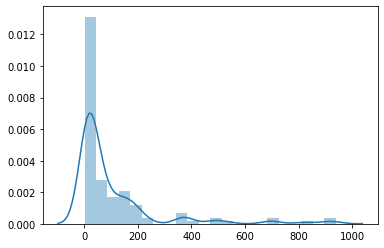

In [89]:
sns.distplot(list(dict(data_bus.groupby('empresa')['onibus'].nunique()).values()))

We see that most companies own less than 200 buses. Let's plot the number of times a given company has travelled against number of buses owned.

In [110]:
companies = list(sorted(companies));
companies_travel = dict()

for company in companies:
    companies_travel[company] = data_bus.empresa.value_counts()[company]

In [112]:
companies_buses = dict()

for company in companies:
    companies_buses[company] = data_bus.groupby('empresa')['onibus'].nunique()[company]

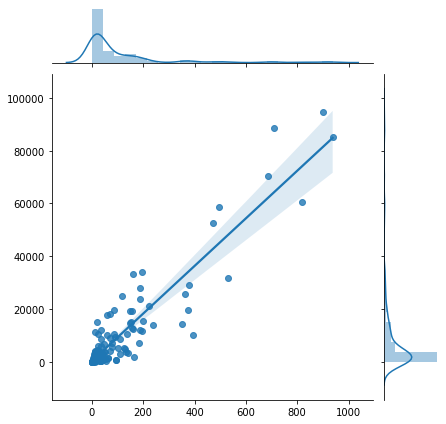

In [127]:
sns.jointplot(list(companies_buses.values()),list(companies_travel.values()), kind='reg')

Captain Obvious: the more buses you have, more times you'll be able to travel. But how many routes a bus does in average?

For this we're going to use the column `nu_linha` and not `codigo_viagem`, as the former indicates the route and the latter is generated each time a bus leaves the bus station.

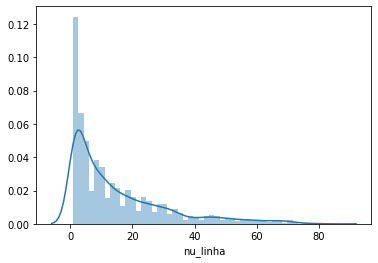

In [172]:
sns.distplot(data_bus.groupby('onibus')['nu_linha'].nunique())

We see that most buses travel less than 20 lines, just a very few travel 60~80 lines. 

Which are the most travelled lines by the 5 biggest companies?

In [210]:
# data_bus.groupby('empresa').groups

data_bus.groupby('empresa').get_group('68f76547').nu_linha.value_counts().index[0]

'd88563dc'

## Network analysis with `NetworkX`
### The making of the graph

There are more than one possible representantion of the bus lines network, with directed graph or multi directed graph. We're going to use directed graph as it's possible to represent both ways of bus lines within the structure of the matrix. 

Let $G$ represent the connections between cities present in our bus lines database, that is, cities that are either origin or destination for interstate bus lines. A value (weight) $g_{i,j}$  may represent the quantity of travelling done from location $i$ to location $j$.


For this, we're going to create a dataframe with columns and rows representing the cities with interstate lines, which in our graph will be the nodes, and in each $g_{i,j}$ there will be the quantity of times that a given line from $i$ to $j$ was travelled.

In [312]:
matrix_quantity = pd.DataFrame(columns = cidades, index=cidades)

for i in cidades:
    matrix_quantity[i][i] = 0

origem_destino = dict(data_bus.groupby(["origem","destino"]).destino.count()) 

for i in cidades:
    for j in cidades:
        try:
            matrix_quantity[i][j] = float(origem_destino[(j,i)])
        except LookupError:
            matrix_quantity[i][j] = 0

# Test to see whether all values are zero. If they are, there's something wrong.

np.all(matrix_quantity==0)


False

If `False` we can proceed, as our dataframe is not all zeros. 

The easiest way to generate our graph is to transform the dataframe into a matrix, as it's the most natural representation in our case.

In [313]:
# Shape the DataFrame matrix_quantity to a NumPy matrix

matrix_quantity = np.asmatrix(matrix_quantity.to_numpy()).astype('float64')

# We had to change the dtype to 'float64' otherwise it would be dtype('O') and networkx would be confused over it.

matrix_quantity.dtype

# From NumPy matrix to networkx graph type
# Naming it Q as Quantity

Q = nx.from_numpy_matrix(matrix_quantity, create_using=nx.DiGraph)

# Checks:

print(type(Q))

Q.number_of_nodes() == len(cidades)


<class 'networkx.classes.digraph.DiGraph'>


True

## Basic network analysis - graph properties

In [314]:
# N: nodes, K: edges

N, K = Q.order(), Q.size()
avg_deg = float(K)/N # Average number of degrees
print(avg_deg)

2.073253833049404


Each node has, in average, 2 degrees. But this isn't representative of our network, since some marginal cities are only origin or destination, while others capital cities receive and send a massive quantity of buses through the country.

For a more interesting analysis we're going to introduce the notions of indegree and outdegree. Simply, we consider indegree the number of edges coming into a node in a directed graph and outdegree the number of edges leaving a node in a directed graph. For more about this, [here](https://doi.org/10.1016/B978-0-12-804452-0.00005-1). 

Within our context, indegree is then the number of bus departures and outdegree the number of bus arrivals.

In [316]:
Q_in = Q.in_degree()

Q_out = Q.out_degree()

# Histogram of # of outdegrees and indegrees

in_values = list(set(sorted(dict(Q_in).values())))

in_hist = [sorted(dict(Q_in).values()).count(x) for x in in_values]

out_values = list(set(sorted(dict(Q_out).values())))

out_hist = [sorted(dict(Q_out).values()).count(x) for x in out_values]

Plotting the indegrees and outdegrees histogram

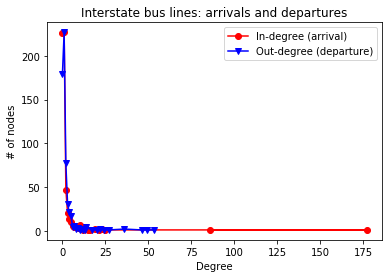

In [317]:
plt.figure()
plt.plot(in_values,in_hist,'ro-')
plt.plot(out_values,out_hist,'bv-')
plt.legend(['In-degree (arrival)','Out-degree (departure)'])
plt.xlabel('Degree')
plt.ylabel('# of nodes')
plt.title('Interstate bus lines: arrivals and departures')
# plt.savefig('interstate_in_out.pdf')
plt.show()

### Centrality measures

#### Betweenness centrality

How many times a node falls on the shortest path between other nodes? 

That is, for nodes $u$, with $v$ and $w$ as any couple of nodes and $\sigma_{v,w}$ the path between $v$ and $w$:

$$B(u) = \sum_{u \neq v \neq w}\frac{\sigma_{v,w}(u)}{\sigma_{v,w}}$$


In [318]:
# Converting the directed to undirected graph

Q_ud = Q.to_undirected()

# The following function will do the math and return a dict type. We'll store it and return to it later

B_Q_ud = nx.betweenness_centrality(Q_ud)

#### Closeness centrality

What about how close a node is, in average, to all other nodes?

We may define closeness as the inverse of farness. Consider $d(u,w)$ as the distance between nodes $u$ and $w$, with $w \in G$. Then

$$C(u) = \sum_{w \in G} \frac{1}{d(u,w)}$$

If the sum is of all distance is large, then the closeness is small and vice-versa. A node with high closeness centrality means a node with close relationships with many other nodes.


In [319]:
# The following function will do the math and return a dict type. We'll store it and return to it later

C_Q_ud = nx.closeness_centrality(Q_ud)

#### Eigenvector centrality

How to measure influence of one node over another? What about one node over the network? Is it the quantity of links? Or who you're connected with? As in [here](https://www.sci.unich.it/~francesc/teaching/network/eigenvector.html):

>A node is important if it is linked to by other important nodes.

Consider our $G$ graph and let $A=(a_{v,t})$ be the adjacency matrix, with $a_{v,t} > 0 $ representing a link between nodes $v$ and $t$ with weight $a_{v,t}$. The relative centrality, $x$, score of vertex $v$ can be defined as:

$$
x_v = \frac{1}{\lambda}\sum_{t \in M(v)} x_t = \frac{1}{\lambda}\sum_{t \in G}a_{v,t}x_{t}
$$

with $M(v)$ as the set of neighbors of $v$ and $\lambda$ a constant. Rearranging, this is

$$
Ax=\lambda x 
$$

In [320]:
# The following function will do the math and return a dict type. We'll store it and return to it later

E_Q_ud = nx.eigenvector_centrality(Q_ud)

### Comparing

Knowing in basic terms what each measure means and how to calculate them, it's time to compare and understand how our graph behaves in face of what we've found. 

For this, it's good to first see what's happening. We know by calling the measures lists that the cities with the highest values are the usual suspects, like São Paulo, Rio de Janeiro and Brasília, so instead focusing on them, let's plot all nodes and compare the measures against each other.

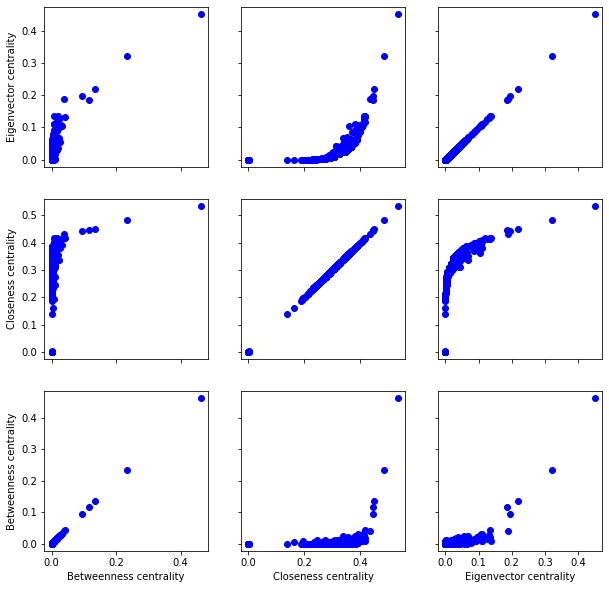

In [321]:
fig, axs = plt.subplots(3,3, sharex='col', sharey='row', figsize=(10,10))

config = 'bo'

B_plot = list(B_Q_ud.values())
C_plot = list(C_Q_ud.values())
E_plot = list(E_Q_ud.values())

plots_graph = [B_plot, C_plot, E_plot]

for i in range(len(plots_graph)):
    for j in range(len(plots_graph)):
        axs[i][j].plot(list(plots_graph[j]),list(plots_graph[-(i+1)]), config)

axs.flat[0].set(ylabel='Eigenvector centrality')
axs.flat[3].set(ylabel='Closeness centrality')
axs.flat[6].set(xlabel='Betweenness centrality', ylabel='Betweenness centrality')
axs.flat[7].set(xlabel='Closeness centrality')
axs.flat[8].set(xlabel='Eigenvector centrality')

for ax in axs.flat:
    ax.label_outer()

plt.show()

A quick look tells us that there is one single city with high value in all measures, São Paulo. The gross part of nodes are gathered, but this subgroup is not homogeneous among the measures. Cities are much more close to each other than they are important in terms of relative influence or in-betweenness of the node.

Looking at the measures by themselves it's also possible to identify that while betweenness centrality and eigenvector centrality are more within low range values, closeness centrality has only one node with low value the others within middle range values.

## Drawing graphs

As our data is geolocated, there are two possibilites for putting things visually: draw the network as usual or plot the nodes geographically. The first is easy, and `NetworkX` and `matplotlib` allows us to do this quickly. It's possible to color the nodes and edges given certain values, as number of routes between two nodes or following a given centrality measure. To plot the nodes geographically gives an extra layer of complication, and the use of GIS, Geographic Information System, and packages like `GeoPandas` and `shapely` are made necessary.

### Drawing with `NetworkX` and `matplotlib`

`NetworkX` offers with `matplotlib`a simple way to draw graphs, including arguments to color and size nodes and edges however we may need. 

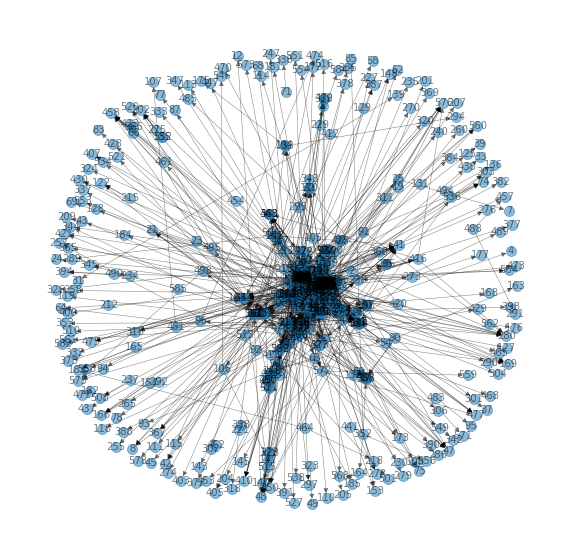

In [323]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
nx.draw_networkx(Q, ax=ax, node_size=100,
                 font_size=10, alpha=.5,
                 width=.5)
ax.set_axis_off()

However, considering that what we have is a location, why not map it into a projection? In order to do so, we must use `cartopy`package, which allows to transform and to project points in a given coordinate reference system.

As we have our `cidades` list, with each city represented by an index (and this index the label of our graph), let's create a position dictionary in the format `{city:(longitude,latitude)}`.

In [325]:
name_pos = {}
pos = {}

for city in cidades:
    lat = municipios_ibge.loc[list(municipios_ibge.nome_uf).index(city)][2]
    long = municipios_ibge.loc[list(municipios_ibge.nome_uf).index(city)][3]
    name_pos[city] = (long,lat)
    pos[list(cidades).index(city)] = (long,lat)


The first dictionary, `name_pos`gives us the city name and its GPS coordinates, while `pos`gives us the city's graph index and its GPS coordinates.

Now it's time to plot using `cartopy`. The use of this package is necessary because the GPS coordinates must be axed to a spatial reference system (SRS), given by a map projection and transformations between different SRS. `cartopy` also offers direct integration with [Natural Earth](https://www.naturalearthdata.com/), allowing use of borders, rivers, oceans, lakes, land, coastlines etc. inside their database. You can also see a quick tutorial on this here at [NASA Modeling Guru](https://modelingguru.nasa.gov/docs/DOC-2602).

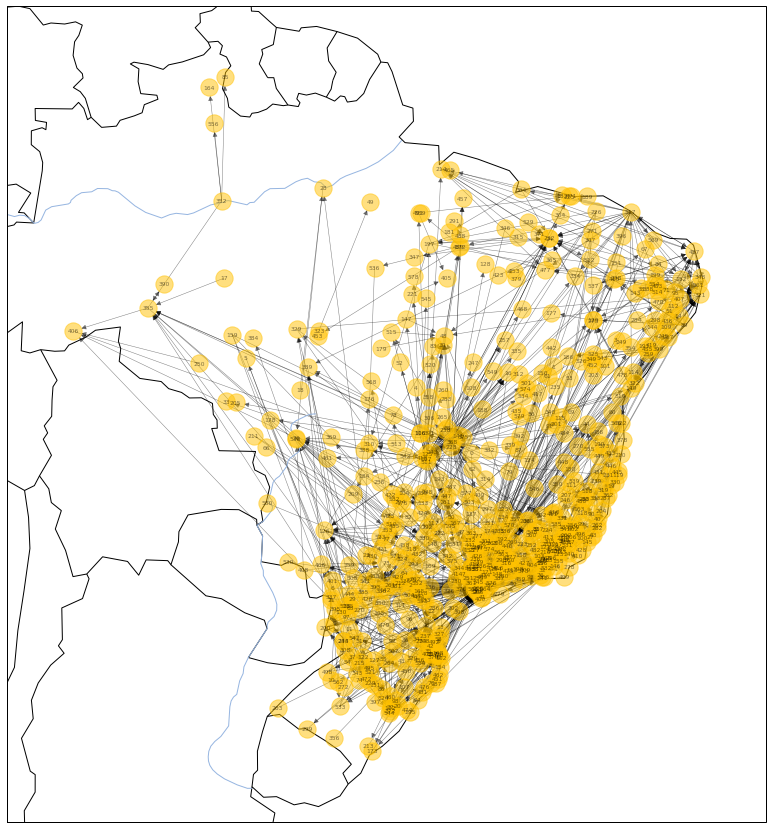

In [326]:
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs


crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(15, 15),
    subplot_kw=dict(projection=crs))

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)

nx.draw_networkx(Q, ax=ax,
                 font_size=6,
                 alpha=.5,
                 width=.5,
                 node_color = '#ffc100',
                 pos=pos)

The map above doesn't give us any fun. Let's color and size nodes and edges in respect to some characteristics inherent to our data. `NetworkX` colors network objects in response to a color string or an array of floats, with indexes in the latter case representing nodes or edges to be colored.

Let's create lists of edges and nodes to be colored and sized.

We created our directed graph using a matrix, with each position $g_{i,j}$ of our graph $G$ representing the number of times that a given route was travelled from node $i$ to node $j$. Organizing this data in an indexed list we have:

In [328]:
weights_ = [d for (u, v, d) in Q.edges(data=True)]
weights = []

for line in weights_:
    (name,weight) = str(line).split(":")
    weight,closekey = weight.split("}")
    weights.append(np.log(float(weight)))
    
len(weights) == len(Q.edges())

True

We have the following parameters to have fun with our graph:
#### Nodes
- `B_Q_ud`: betweenness centrality measure for each node
- `C_Q_ud`: closeness centrality measure for each node
- `E_Q_ud`: eigenvector centrality measure for each node
- `Q.degree(v)`: degree of vector `v`
- `Q.in_degree(v)`: indegree of vector `v`
- `Q.out_degree(v)`: outdegree of vector `v`


#### Edges
-  `weights`: number of times that a given route (edge) was travelled

Using `weights`, `B_Q_ud` and `Q.degree`, we have the following map:

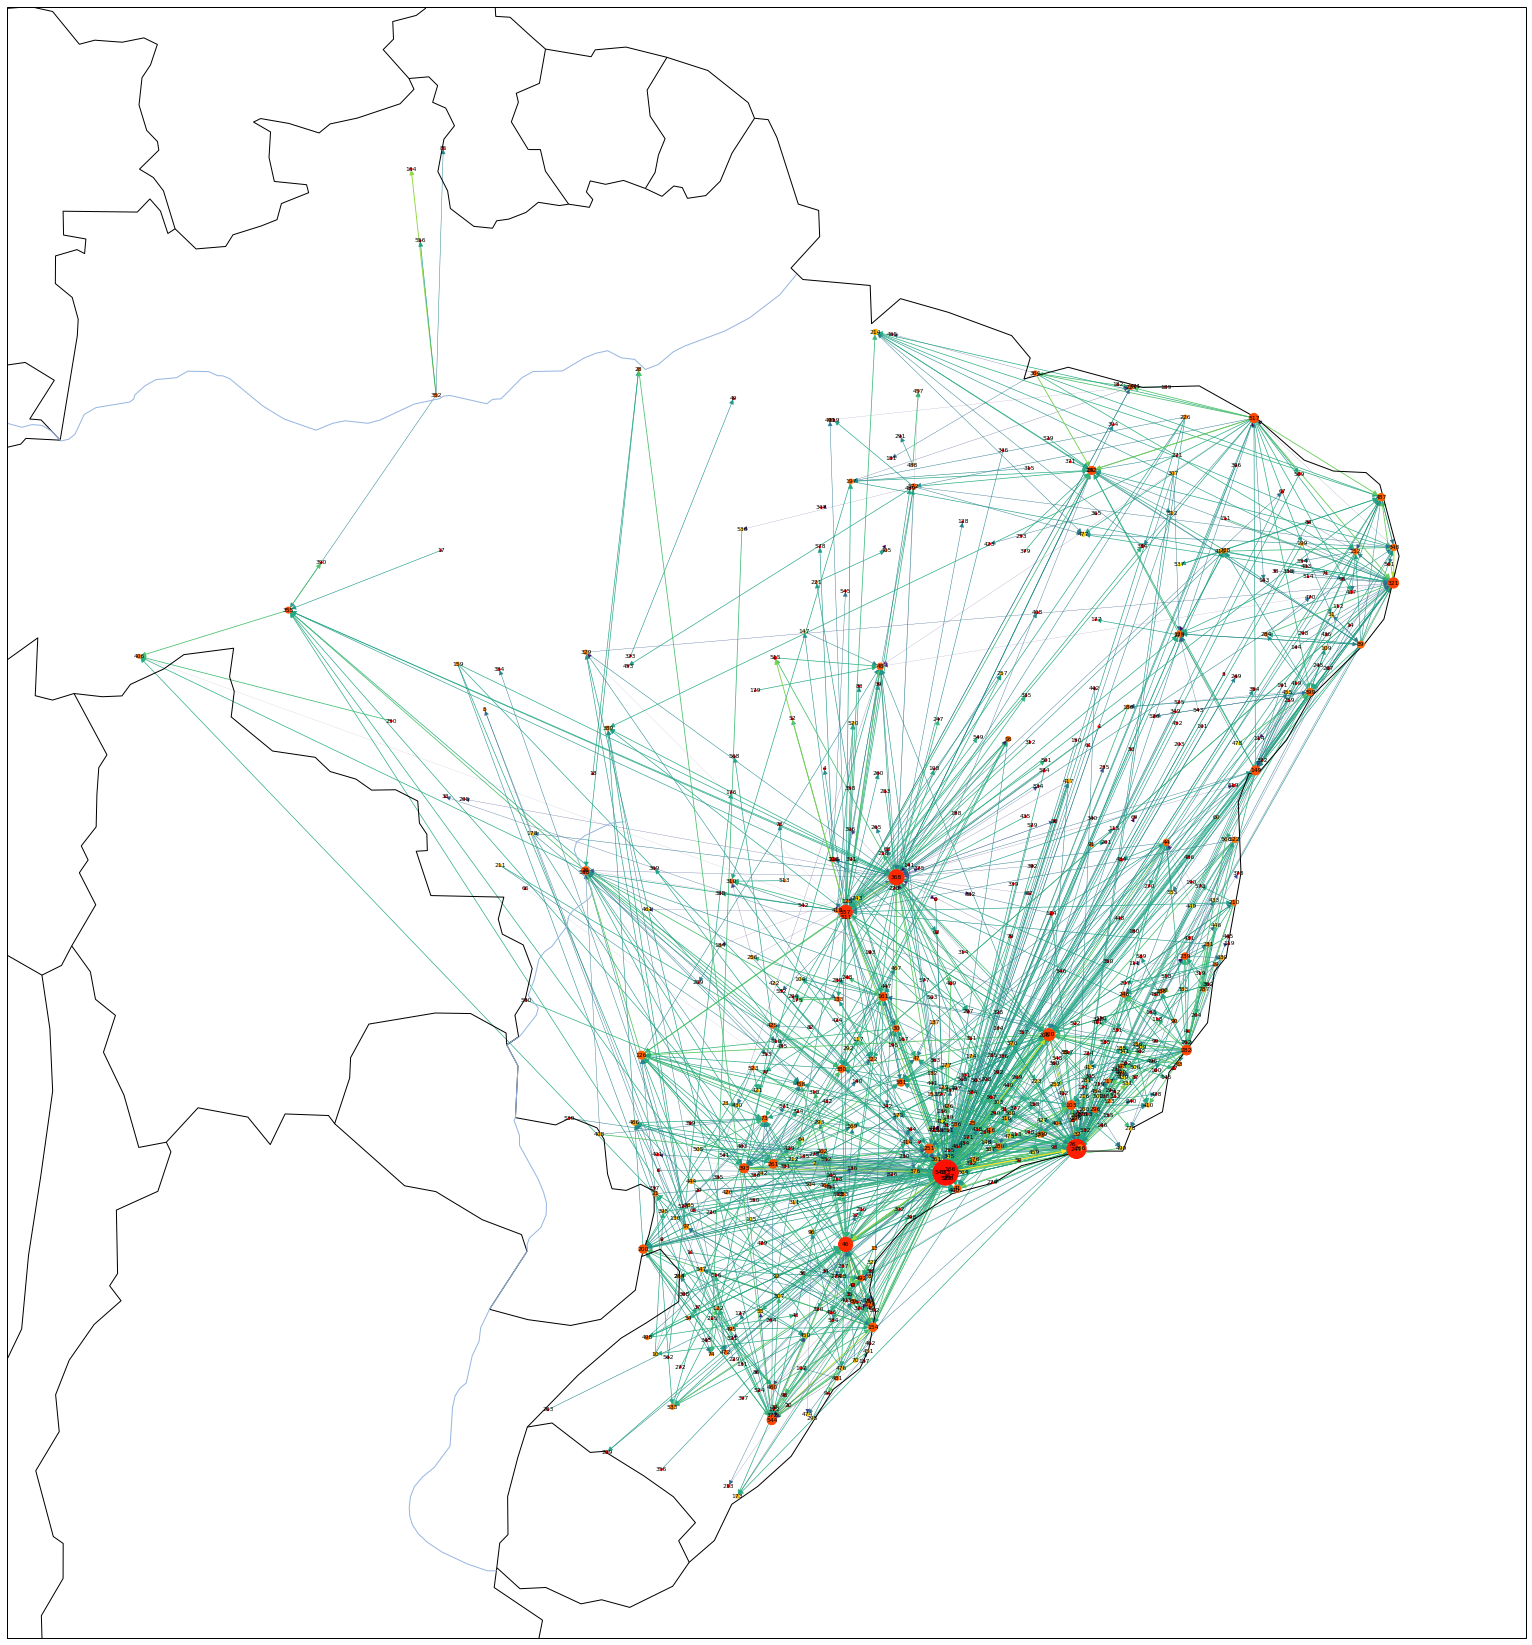

In [330]:
crs = ccrs.PlateCarree()

fig, ax = plt.subplots(
    1, 1, figsize=(30, 30),
    subplot_kw=dict(projection=crs))

ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS)
ax.add_feature(cartopy.feature.RIVERS)


node_size = [float(B_Q_ud[v])*10**4 for v in B_Q_ud]
node_color = [np.log(float(B_Q_ud[v])) if B_Q_ud[v] > 0 else 0 for v in B_Q_ud]

nx.draw_networkx(Q, ax=ax,
                 font_size=6,
#                  alpha=.5,
                 width=[x/10 for x in weights],
                 pos=pos,
                 node_color = node_color,
                 node_size = [3*Q.degree[x] for x in range(len(Q.degree))],
                 cmap = plt.cm.autumn_r,
                 edge_color = weights,
                 edge_cmap = plt.cm.viridis)

plt.show()